# Cifar-10 이미지 분류

In [1]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [2]:
# seed 값 설정
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# 나중에 지정될 변수의 값을 미리 셋팅
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 50
DATA_AUGMENTATION = True
NUM_PREDICTIONS = 20
SAVE_DIR = os.path.join(os.getcwd(), 'model')

In [5]:
# The data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = cifar10.load_data()
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 19s 0us/step
x_train shape:  (50000, 32, 32, 3)
50000 train samples
10000 test samples


## 데이터 확인

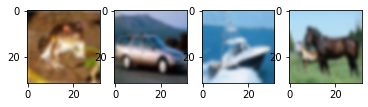

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(141)
plt.imshow(x_train[0], interpolation='bicubic')
plt.grid(False)

plt.subplot(142)
plt.imshow(x_train[4], interpolation='bicubic')
plt.grid(False)

plt.subplot(143)
plt.imshow(x_train[8], interpolation='bicubic')
plt.grid(False)

plt.subplot(144)
plt.imshow(x_train[12], interpolation='bicubic')
plt.grid(False)

plt.show()

In [7]:
# 자료형을 실수로 변환한 후 정규화
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [8]:
# 원핫 인코딩
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train0, NUM_CLASSES)
y_test = to_categorical(y_test0, NUM_CLASSES)
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

## 모델 정의/설정/학습

In [9]:
model = Sequential()

# 마스크의 갯수(32), 사이즈(3,3)
model.add(Conv2D(32, (3,3), padding='same',
                 input_shape=x_train.shape[1:], activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [10]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(learning_rate=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
modelpath = 'model/cifar10-augmentation-{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss',
                               verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [15]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
  featurewise_center=False, # set input mean to 0 over the dataset 
  samplewise_center=False, # set each sample mean to 0 
  featurewise_std_normalization=False, # divide inputs by std of dataset 
  samplewise_std_normalization=False, # divide each input by its std 
  zca_whitening=False, # apply ZCA whitening
  zca_epsilon=1e-06, # epsilon for ZCA whitening
  rotation_range=0, # randomly rotate images in the range (deg 0 to 180) 
  width_shift_range=0.1, # randomly shift images horizontally 
  height_shift_range=0.1, # randomly shift images vertically
  shear_range=0., # set range for random shear
  zoom_range=0., # set range for random zoom
  channel_shift_range=0., # set range for random channel shifts 
  fill_mode='nearest', # set mode for filling points outside the input boundaries 
  cval=0., # value used for fill_mode = "constant"
  horizontal_flip=True, # randomly flip images
  vertical_flip=False, # randomly flip images
  rescale=None, # set rescaling factor (applied before any other transformation) 
  preprocessing_function=None, # set function that will be applied on each input 
  data_format=None, # image data format, either "channels_first" or "channels_last" 
  validation_split=0.0 # fraction of images reserved for validation
)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, stratify=y_train, test_size=0.2, random_state=seed
)

In [23]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=(x_valid, y_valid),
                    shuffle=True,
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/50
938/938 [==============================] - 16s 17ms/step - loss: 1.4970 - accuracy: 0.4545 - val_loss: 1.3439 - val_accuracy: 0.5139

Epoch 00001: val_loss improved from 1.44920 to 1.34395, saving model to model/cifar10-augmentation-01-1.3439.hdf5
Epoch 2/50
938/938 [==============================] - 16s 17ms/step - loss: 1.4396 - accuracy: 0.4810 - val_loss: 1.2951 - val_accuracy: 0.5369

Epoch 00002: val_loss improved from 1.34395 to 1.29512, saving model to model/cifar10-augmentation-02-1.2951.hdf5
Epoch 3/50
938/938 [==============================] - 16s 17ms/step - loss: 1.4026 - accuracy: 0.4944 - val_loss: 1.3205 - val_accuracy: 0.5176

Epoch 00003: val_loss did not improve from 1.29512
Epoch 4/50
938/938 [==============================] - 16s 17ms/step - loss: 1.3608 - accuracy: 0.5107 - val_loss: 1.1920 - val_accuracy: 0.5776

Epoch 00004: val_loss improved from 1.29512 to 1.19196, saving model to model/cifar10-augmentation-04-1.1920.hdf5
Epoch 5/50
938/938 [=======

In [24]:
from tensorflow.keras.models import load_model
best_model = load_model('model/cifar10-augmentation-50-0.7399.hdf5')

# 테스트 정확도 출력
acc = model.evaluate(x_test, y_test, verbose=2)[1]
print('Test Accuracy: {:.4f}'.format(acc))

313/313 - 1s - loss: 0.7496 - accuracy: 0.7564
Test Accuracy: 0.7564


## 훈련과정 시각화

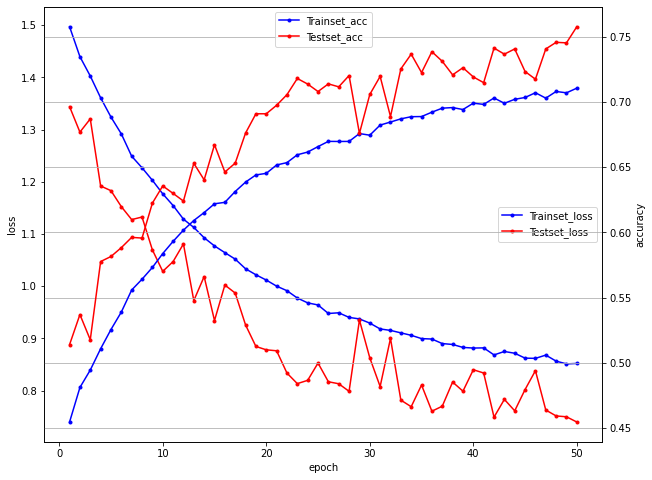

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

# 검증셋의 오차
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']

# 학습셋의 정확도
y_loss = history.history['loss']
y_acc = history.history['accuracy']

# 그래프로 표현
x_len = np.arange(1, len(y_loss) + 1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()

ax0.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')
ax0.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
ax0.set_xlabel('epoch')
ax0.set_ylabel('loss')
ax0.legend(loc='center right')

ax1.plot(x_len, y_acc, marker='.', c='blue', label='Trainset_acc')
ax1.plot(x_len, y_vacc, marker='.', c='red', label='Testset_acc')
ax1.set_ylabel('accuracy')
ax1.legend(loc='upper center')

# 그래프에 그리드를 그리고 레이블을 표시
plt.grid()
plt.show()